In [2]:
import psycopg2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

from pprint import pprint

try:
  con
except NameError:
  con = psycopg2.connect(user="postgres", dbname="timeoutdb", password="coap")
  con.set_session(readonly=True, autocommit=False)
    

In [3]:
exp_data_sql = """
SELECT 
    ex.exp_id,
    ex.num_trials, 
    d.dnid,
    n.*
FROM 
	experiment ex
  JOIN deployed_node d ON d.exp_id = ex.exp_id
  JOIN node n ON d.node_id = n.node_id
  JOIN event e ON e.observer_id = d.dnid
GROUP BY
	ex.exp_id,
    n.node_id,
    d.dnid
ORDER BY
  ex.attacker_rate,
  ex.proxy_connections
;
"""
lay_of_the_land = pd.read_sql_query(exp_data_sql, con)
con.commit()
print("\n".join(lay_of_the_land.exp_id.unique().tolist()))
lay_of_the_land

quadruple_delay_halftimeout1_90conns_1client_1attackers_longrunning_newreala


,exp_id,num_trials,dnid,node_id,node_name,hardware_type,operating_system
0,quadruple_delay_halftimeout1_90conns_1client_1...,1,4,1,originserver,microcloud,ubuntu1804-std
1,quadruple_delay_halftimeout1_90conns_1client_1...,1,6,2,receiver,dl380g3,ubuntu1804-std
2,quadruple_delay_halftimeout1_90conns_1client_1...,1,1,3,attacker,microcloud,ubuntu1804-std
3,quadruple_delay_halftimeout1_90conns_1client_1...,1,5,4,proxy,microcloud,ubuntu1804-std
4,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,5,client1,microcloud,ubuntu1804-std


In [4]:
exp_id = "quadruple_delay_halftimeout1_90conns_1client_1attackers_longrunning_newreala"

node_map_node_id = dict()
node_map_dnid = dict()

df = lay_of_the_land
records = df[(df["exp_id"] == exp_id)][["node_name", "dnid", "node_id"]].to_records(index=False)
client_node_ids = set()
client_dnids = set()
proxy_node_id = None
for node_name, dnid, node_id in records:
    node_map_node_id[node_name] = node_id
    node_map_dnid[node_name] = dnid
    if node_name.startswith("client"):
        client_node_ids.add(node_id)
        client_dnids.add(dnid)
    elif node_name == 'proxy':
        proxy_node_id = node_id
    
pprint(node_map_node_id)
pprint(node_map_dnid)
pprint(client_node_ids)
pprint(client_dnids)
pprint(proxy_node_id)

{'attacker': 3, 'client1': 5, 'originserver': 1, 'proxy': 4, 'receiver': 2}
{'attacker': 1, 'client1': 2, 'originserver': 4, 'proxy': 5, 'receiver': 6}
{5}
{2}
4


In [5]:
summary_sql = f"""
SELECT 
	n.node_name AS observer,
	e.trial,
	COUNT (DISTINCT e.message_marker) AS unique_messages,
	COUNT (e.message_marker) AS total_messages,
	MIN(e.observe_timestamp) min_timestamp_sec,
	MAX(e.observe_timestamp) max_timestamp_sec,
	MAX(e.observe_timestamp) - MIN(e.observe_timestamp) active_time_sec
FROM 
	deployed_node d 
	JOIN node n ON n.node_id = d.node_id
	JOIN "event" e ON e.observer_id = d.dnid
WHERE 
	d.exp_id = '{exp_id}'
GROUP BY
	n.node_name,
	e.trial
"""

sdf = pd.read_sql_query(summary_sql, con)
con.commit()
sdf

,observer,trial,unique_messages,total_messages,min_timestamp_sec,max_timestamp_sec,active_time_sec
0,attacker,1,514942,514942,1.643141e+09,1.643141e+09,19.846064
1,client1,1,724,2177,1.643141e+09,1.643141e+09,198.944685
2,originserver,1,14236,28507,1.643141e+09,1.643141e+09,199.090029
3,proxy,1,515659,1516297,1.643141e+09,1.643141e+09,199.753330
4,receiver,1,217604,217604,1.643141e+09,1.643141e+09,51.544622


In [8]:
%%time

client_messages_sql = f"""
WITH client_msgs AS (
SELECT
    dn.exp_id,
	e.trial,
	e.observer_id,
    e.message_marker,
	e.observe_timestamp,
	m.src_id, 
    cm.coap_code,
	cm.coap_retransmitted
FROM
	event e
	JOIN deployed_node dn ON dn.dnid = e.observer_id
	JOIN message m ON e.message_id = m.message_id
    JOIN coap_message cm ON cm.cmci = m.coap_message
WHERE
	e.observer_id IN ({','.join(map(str, client_dnids))}) -- all client dnids
ORDER BY
	e.observe_timestamp
), client_sends AS (
SELECT *
FROM client_msgs
WHERE src_id != {proxy_node_id} -- message source is not the proxy 
), client_recvs AS (
SELECT *
FROM client_msgs
WHERE src_id = {proxy_node_id} -- message source is the proxy 
), msgs_summary AS (
SELECT 
	cm.exp_id,
	cm.trial,
	cm.observer_id,
	cm.message_marker,
	COUNT(cm.*) AS num_observations,
	SUM(CASE WHEN cm.coap_retransmitted = true THEN 1 ELSE 0 END) AS num_retransmissions
FROM 
	client_msgs cm
GROUP BY
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
ORDER BY 
	cm.exp_id, cm.trial, cm.observer_id, cm.message_marker
), timestamps_summary AS (
SELECT 
	cm.exp_id, 
	cm.trial, 
	cm.observer_id, 
	MIN(observe_timestamp) AS min_observe_timestamp, 
	MAX(observe_timestamp) AS max_observe_timestamp
FROM client_msgs cm
GROUP BY cm.exp_id, cm.trial, cm.observer_id
ORDER BY cm.exp_id, cm.trial, cm.observer_id
), main_table AS (
SELECT 
	cs.exp_id,
	cs.trial,
	cs.observer_id,
    cs.message_marker,
	1e3 * (MAX(cr.observe_timestamp) - MIN(cs.observe_timestamp)) AS rtt_ms_first_transmission,
	1e3 * (MAX(cr.observe_timestamp) - MAX(cs.observe_timestamp)) AS rtt_ms_last_transmission,
	-- MIN is ok to use as "first in aggregation group" since all 
	-- values are expected to be the same in the GROUP BY group
	MIN(cs.observe_timestamp) - MIN(min_observe_timestamp) AS send_time_sec,
	MAX(cr.observe_timestamp) - MIN(min_observe_timestamp) AS recv_time_sec,
	MIN(ms.num_observations) AS num_observations,
	MIN(ms.num_retransmissions) AS num_retransmissions
FROM 
	client_sends cs
	LEFT JOIN client_recvs cr
		ON cs.exp_id = cr.exp_id 
		AND cs.trial = cr.trial
		AND cs.observer_id = cr.observer_id
		AND cs.message_marker = cr.message_marker
	JOIN timestamps_summary ts
		ON cs.exp_id = ts.exp_id 
		AND cs.trial = ts.trial
		AND cs.observer_id = ts.observer_id
	, msgs_summary ms
WHERE
	cs.exp_id = ms.exp_id
	AND cs.trial = ms.trial
	AND cs.observer_id = ms.observer_id
	AND cs.message_marker = ms.message_marker
GROUP BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
ORDER BY cs.exp_id, cs.trial, cs.observer_id, cs.message_marker
), rps_stats AS (
SELECT 
	mt.exp_id,
	mt.trial,
	mt.observer_id,
	COUNT(DISTINCT mt.message_marker) AS num_messages,
	MAX(mt.recv_time_sec) AS last_receive_time_sec,
	MIN(mt.send_time_sec) AS first_send_time_sec,
	COUNT(DISTINCT mt.message_marker) / (MAX(mt.recv_time_sec) - MIN(mt.send_time_sec)) AS average_rps
FROM main_table mt
GROUP BY mt.exp_id, mt.trial, mt.observer_id
)

SELECT mt.*, rs.num_messages, rs.average_rps
FROM main_table mt
JOIN rps_stats rs
	ON mt.exp_id = rs.exp_id
	AND mt.trial = rs.trial
	AND mt.observer_id = rs.observer_id
"""

rtts_df = pd.read_sql_query(client_messages_sql, con)
con.commit()

rtts_df

CPU times: user 15.9 ms, sys: 1.91 ms, total: 17.8 ms
Wall time: 769 ms


,exp_id,trial,observer_id,message_marker,rtt_ms_first_transmission,rtt_ms_last_transmission,send_time_sec,recv_time_sec,num_observations,num_retransmissions,num_messages,average_rps
0,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,1,708.084106,708.084106,0.000000,0.708084,3,0,724,3.639217
1,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,2,205.674887,205.674887,0.722143,0.927818,3,0,724,3.639217
2,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,3,204.964161,204.964161,0.929739,1.134703,3,0,724,3.639217
3,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,4,204.916000,204.916000,1.136898,1.341814,3,0,724,3.639217
4,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,5,205.512047,205.512047,1.344145,1.549657,3,0,724,3.639217
...,...,...,...,...,...,...,...,...,...,...,...,...
719,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,515662,202.198029,202.198029,198.132899,198.335097,3,0,724,3.639217
720,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,515663,202.198029,202.198029,198.335880,198.538078,3,0,724,3.639217
721,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,515664,202.272892,202.272892,198.538865,198.741138,3,0,724,3.639217
722,quadruple_delay_halftimeout1_90conns_1client_1...,1,2,515665,201.989174,201.989174,198.741917,198.943906,3,0,724,3.639217


In [6]:
rtts_df[["rtt_ms_first_transmission", "rtt_ms_last_transmission"]].describe()

,rtt_ms_first_transmission,rtt_ms_last_transmission
count,723.000000,723.000000
mean,274.073857,226.527736
std,1283.559241,449.521602
min,201.773167,201.773167
25%,202.166080,202.166080
50%,202.215195,202.215195
75%,202.270389,202.270389
max,31497.096062,11293.316841


<IPython.core.display.Javascript object>


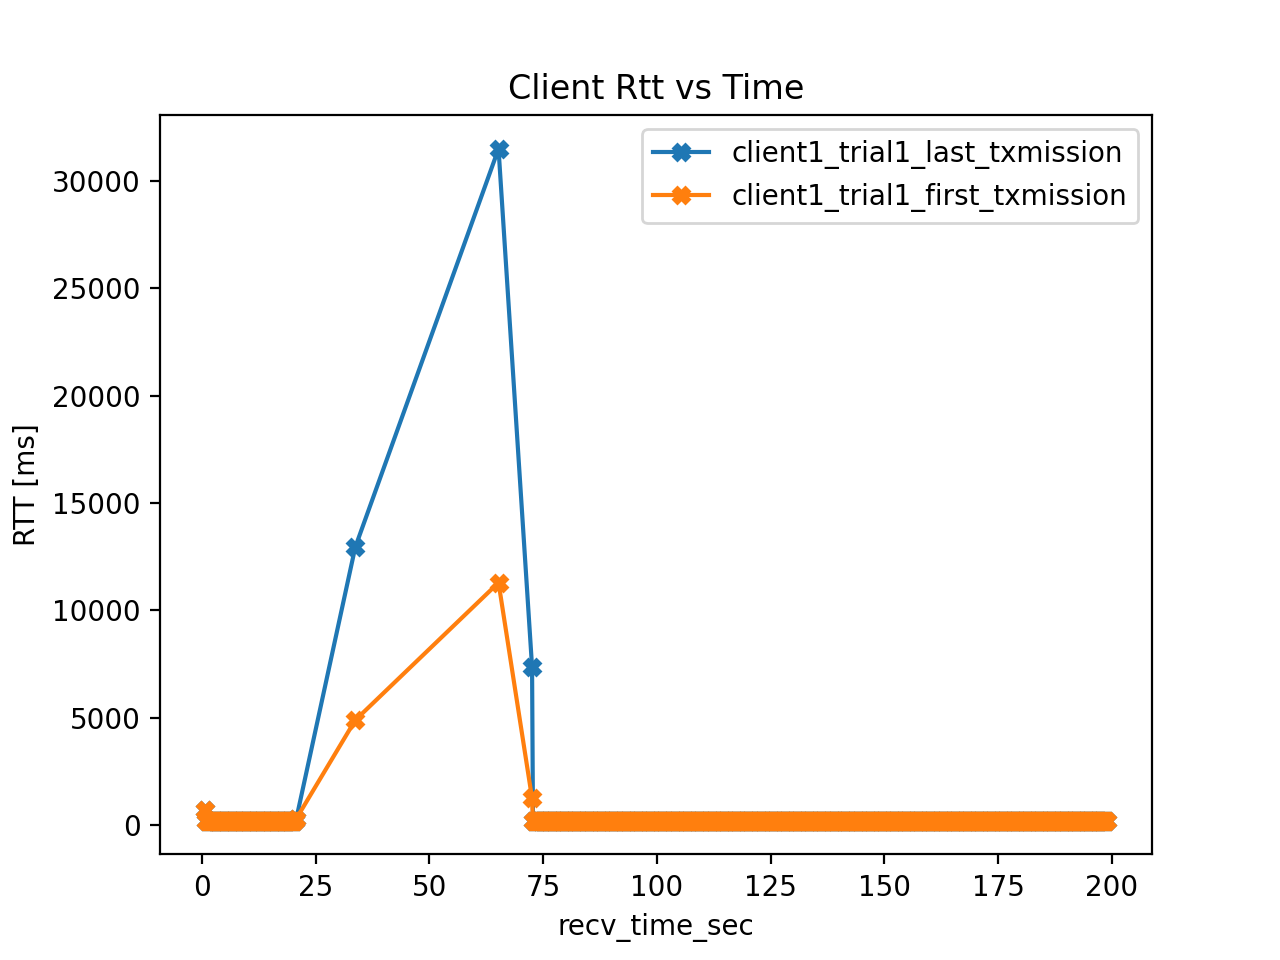

In [7]:
%matplotlib notebook

ignore_clients = {}
ignore_trials = {}

ax = None
kind = "line"
color_map = {(1,0): "orange", (1,1): "blue", (1,2): "red", (1,3): "black",
             (2,0): "skyblue", (2,1): "brown", (2,2): "gold", (2,3): "maroon",
             (3,0): "silver", (3,1): "green", (3,2): "purple", (3,3): "pink"}
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = trial_df[trial_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        
        # RTT since first transmission
        last_txmission = label + "_last_txmission"
        plot_args = {"kind": kind,
                     "x": "recv_time_sec",
                     "y": "rtt_ms_first_transmission",
                     "label": last_txmission,
                     "marker": 'X'}
        if ax:
            plot_args += {"ax": ax}
        
        ax = client_trial_df.plot(**plot_args)
        plot_args["ax"] = ax

        # RTT since last transmission
        first_txmission = label + "_first_txmission"
        plot_args["label"] = first_txmission
        plot_args["y"] = "rtt_ms_last_transmission"
        ax = client_trial_df.plot(**plot_args)

ax.set_title("Client Rtt vs Time")
ax.set_ylabel("RTT [ms]")
plt.show()

<IPython.core.display.Javascript object>


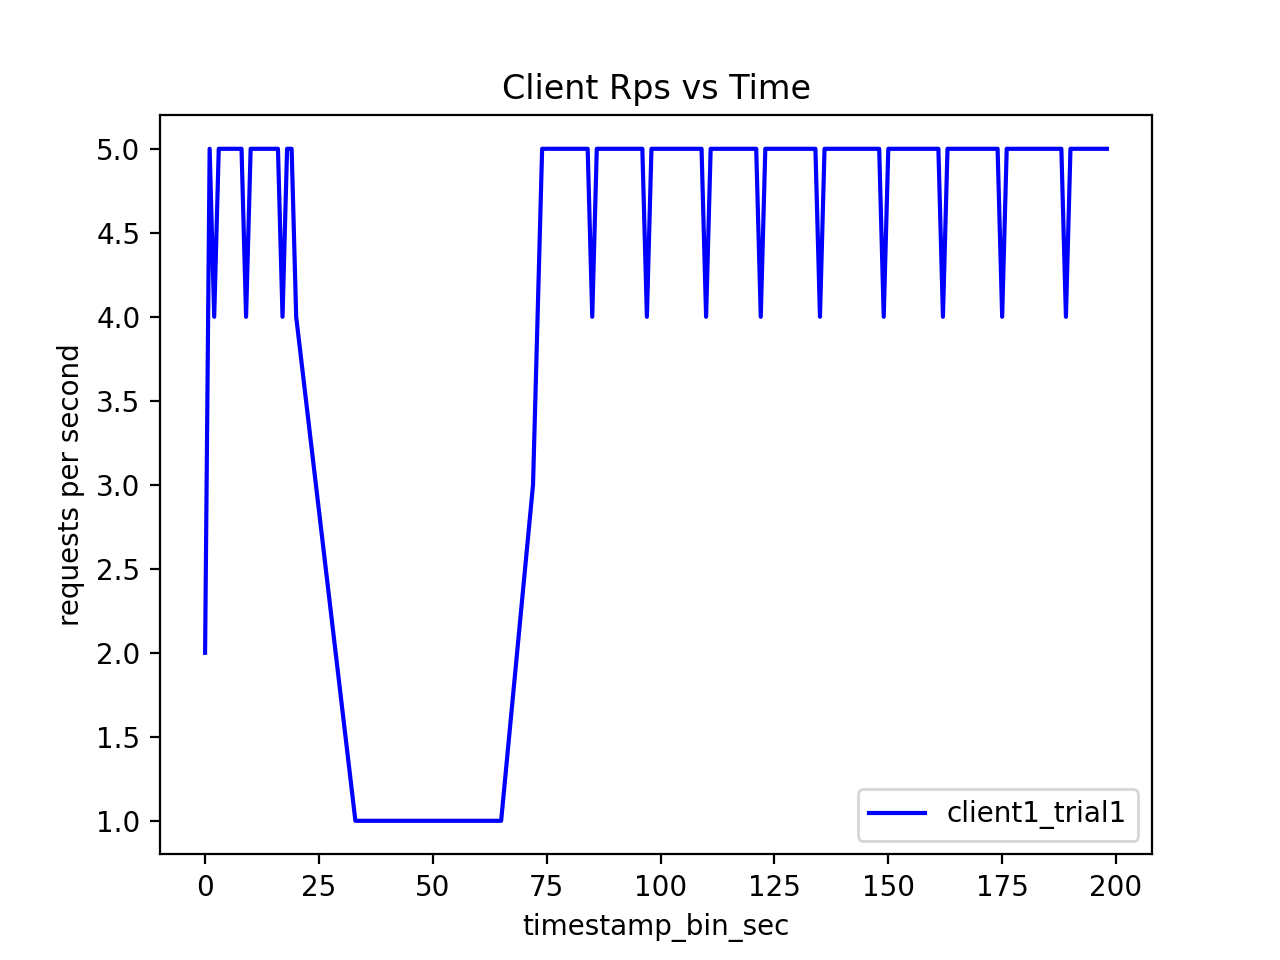

,timestamp_bin_sec,observer_id,packets_per_second
0,0.0,2,2
1,1.0,2,5
2,2.0,2,4
3,3.0,2,5
4,4.0,2,5
...,...,...,...
145,194.0,2,5
146,195.0,2,5
147,196.0,2,5
148,197.0,2,5


In [8]:
trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])

ignore_clients = {}
ignore_trials = {4, 5}

ax = None
for t in rtts_df["trial"].unique():
    if t in ignore_trials:
        continue
    trial_df = rtts_df[rtts_df["trial"] == t]
    min_timestamp = trial_df["recv_time_sec"].min()
    trial_df["timestamp_bin_sec"] = np.floor(trial_df["recv_time_sec"])
    time_stats_df = trial_df.groupby(by=["timestamp_bin_sec", "observer_id"]).agg(\
                                             packets_per_second=("average_rps", "count")).reset_index()
    
    for client_number, src_id in enumerate(trial_df["observer_id"].unique(), start=1):
        if client_number in ignore_clients:
            continue
        client_trial_df = time_stats_df[time_stats_df["observer_id"] == src_id]
        label = f"client{client_number}_trial{t}"
        color = color_map[(t, client_number)]
        ax = client_trial_df.plot(kind="line", x="timestamp_bin_sec", y="packets_per_second", ax=ax, color=color, label=label)

ax.set_title("Client Rps vs Time")
ax.set_ylabel("requests per second")
plt.show()

time_stats_df

<IPython.core.display.Javascript object>


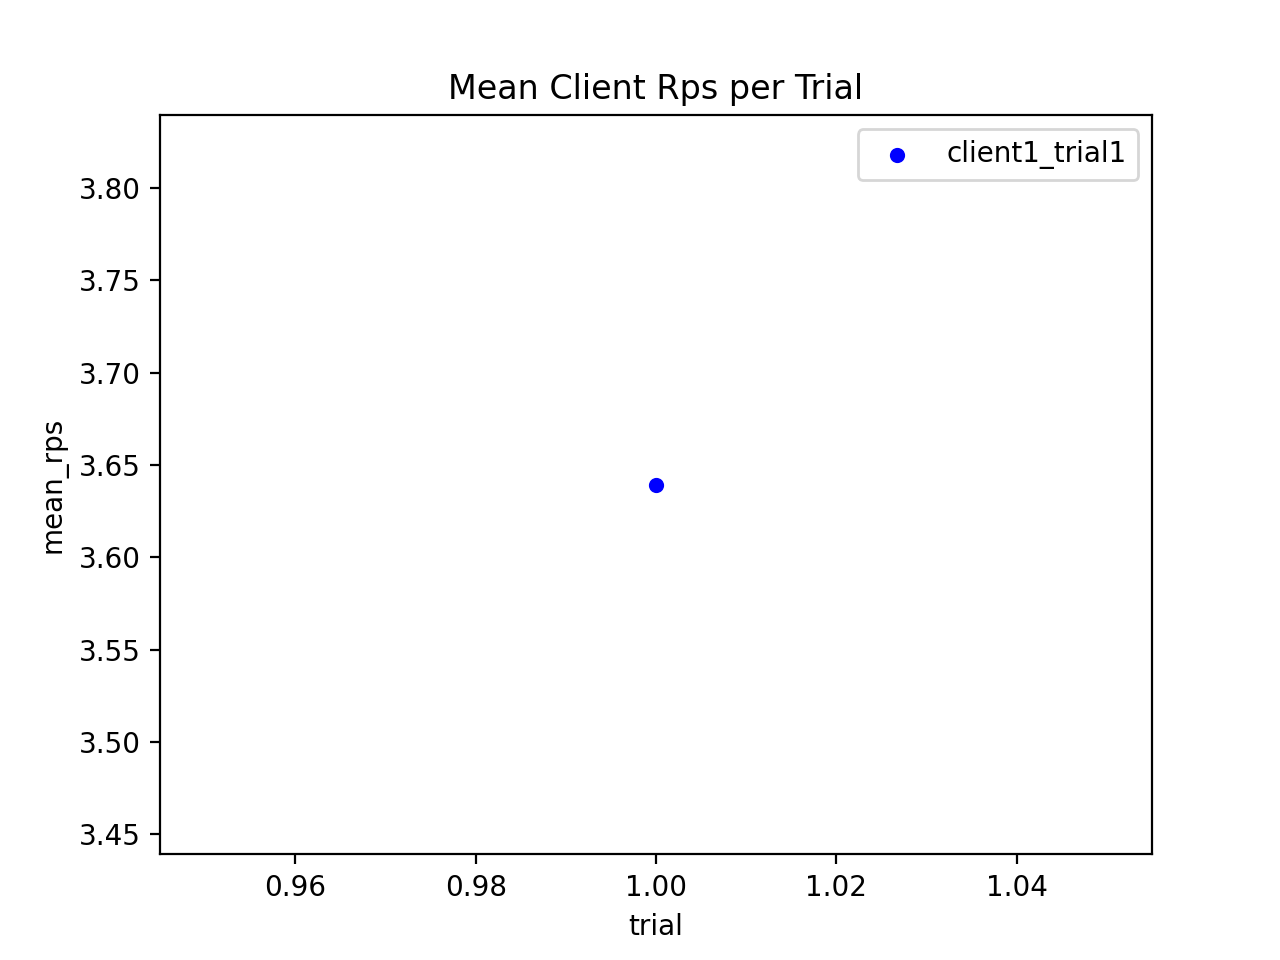

   trial  mean_rps
0      1  3.639217


,observer_id,trial,mean_rps
0,2,1,3.639217


In [9]:
gdf = rtts_df.groupby(by=["observer_id", "trial"]).agg(mean_rps=("average_rps", "mean")).reset_index()

ax = None
for t in gdf["trial"].unique():
    tdf = gdf[gdf["trial"] == t]
    for client_number, src_id in enumerate(tdf["observer_id"].unique(), start=1):
        cdf = tdf[tdf["observer_id"] == src_id]
        cdf["client_number"] = client_number
        ax = cdf.plot(kind="scatter", x="trial", y="mean_rps", ax=ax, label=f"client{client_number}_trial{t}", color=color_map[(t, client_number)])
        
print(gdf.groupby(by=["trial"]).mean().reset_index()[["trial", "mean_rps"]])
       
ax.set_title("Mean Client Rps per Trial")
plt.show()

gdf

In [10]:
attack_dbg_sql = f"""

WITH proxy AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["proxy"]} -- proxy is observer
), proxy_from_server AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["originserver"]} AND dst_id = {node_map_node_id["proxy"]} -- server --> proxy
), proxy_from_attacker AS (
SELECT 
	*
FROM 
	proxy
WHERE
	src_id = {node_map_node_id["receiver"]} AND dst_id = {node_map_node_id["proxy"]} -- attacker (spoofing as receiver) --> proxy
), exp_server AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["originserver"]} -- server is observer
), server_from_proxy AS (
SELECT 
	*
FROM 
	exp_server
WHERE
	src_id = {node_map_node_id["proxy"]} AND dst_id = {node_map_node_id["originserver"]} -- proxy --> server
), receiver AS (
SELECT 
	e.*,
	m.src_id,
	m.dst_id,
	cm.*,
	hm.*
FROM
	event e
	LEFT JOIN message m ON m.message_id = e.message_id
	LEFT JOIN coap_message cm ON cm.cmci = m.coap_message
	LEFT JOIN http_message hm ON hm.hmci = m.http_message
WHERE 
	e.observer_id = {node_map_dnid["receiver"]} -- receiver is observer
), experiment_timestamps AS (
SELECT 
	MIN(x.observe_timestamp) AS min_timestamp,
	MAX(x.observe_timestamp) AS max_timestamp
FROM 
	event x 
WHERE 
	x.observer_id = {node_map_dnid["proxy"]} OR x.observer_id IN ({','.join(map(str, client_dnids))}) -- proxy or client
), main_table AS (
SELECT 
	dn.exp_id,
	e.trial,
	e.message_marker,
	
	r.coap_type,
	r.coap_code,
	r.coap_retransmitted,
	
	sfp.src_id AS sfp_src_id,
	sfp.dst_id AS sfp_dst_id,
	
	e.observe_timestamp - min_timestamp   AS a_observe_timestamp,
	pfa.observe_timestamp - min_timestamp AS pfa_observe_timestamp,
	sfp.observe_timestamp - min_timestamp AS sfp_observe_timestamp,
	pfs.observe_timestamp - min_timestamp AS pfs_observe_timestamp,
	r.observe_timestamp - min_timestamp   AS r_observe_timestamp,
	
	1e3 * (pfa.observe_timestamp - e.observe_timestamp)   AS attacker_to_proxy_ms,
	1e3 * (sfp.observe_timestamp - pfa.observe_timestamp) AS proxy_to_server_ms,
	1e3 * (pfs.observe_timestamp - sfp.observe_timestamp) AS server_to_proxy_ms,
	1e3 * (r.observe_timestamp   - pfs.observe_timestamp) AS proxy_to_receiver_ms,
	1e3 * (r.observe_timestamp   - e.observe_timestamp)   AS attacker_to_receiver_ms
FROM
	event e
	JOIN deployed_node dn             ON dn.dnid            = e.observer_id
	LEFT JOIN proxy_from_attacker pfa ON pfa.message_marker  = e.message_marker
	LEFT JOIN server_from_proxy sfp   ON sfp.message_marker = e.message_marker
	LEFT JOIN proxy_from_server pfs   ON pfs.message_marker = e.message_marker
	LEFT JOIN receiver r              ON r.message_marker   = e.message_marker
	, experiment_timestamps
WHERE 
	e.observer_id = {node_map_dnid["attacker"]} -- attacker is observer for e
), main_table_summary AS (
	SELECT
		COUNT(DISTINCT x.message_marker) AS num_unique_messages,
		COUNT(x.message_marker) AS num_messages
	FROM
		main_table x
), massaged_main_table AS (
SELECT 
	mts.*,
	mt.*
FROM
	main_table mt,
	main_table_summary mts
ORDER BY
	mt.exp_id,
	mt.trial,
	mt.message_marker
), duplicate_messages AS (
SELECT a.*
FROM massaged_main_table a
JOIN (SELECT exp_id, trial, message_marker, COUNT(*)
FROM massaged_main_table 
GROUP BY exp_id, trial, message_marker
HAVING count(*) > 1 ) b
ON a.exp_id = b.exp_id
AND a.trial = b.trial
AND a.message_marker = b.message_marker
ORDER BY a.exp_id, a.trial, a.message_marker
)

SELECT *
FROM massaged_main_table 
;
"""

adbgdf = pd.read_sql_query(attack_dbg_sql, con)
adbgdf["sent_time_ms"] = adbgdf["a_observe_timestamp"]
adbgdf.sort_values(by="sent_time_ms", inplace=True)
con.commit()

adbgdf

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms
0,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,99,ack,content,False,4.0,1.0,...,20.486581,20.797085,20.891640,21.171289,-5.952120,310.504198,94.554901,279.649019,678.755999,20.492533
1,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,99,ack,content,False,4.0,1.0,...,20.486591,20.797085,20.891640,21.171289,-5.942106,310.494184,94.554901,279.649019,678.755999,20.492533
2,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,100,ack,content,False,4.0,1.0,...,20.486594,20.797008,20.891729,21.171261,-5.951166,310.413837,94.721317,279.531956,678.715944,20.492545
3,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,100,ack,content,False,4.0,1.0,...,20.486597,20.797008,20.891729,21.171261,-5.948067,310.410738,94.721317,279.531956,678.715944,20.492545
4,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,101,ack,content,False,4.0,1.0,...,20.486744,20.797119,20.891885,21.171279,-5.802870,310.374975,94.765902,279.393911,678.731918,20.492547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1028267,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,515040,None,None,None,NaN,NaN,...,40.332346,NaN,NaN,NaN,-6.142139,NaN,NaN,NaN,NaN,40.338488
1028268,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,515041,None,None,None,NaN,NaN,...,40.332347,NaN,NaN,NaN,-6.199121,NaN,NaN,NaN,NaN,40.338546
1028269,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,515041,None,None,None,NaN,NaN,...,40.332349,NaN,NaN,NaN,-6.197214,NaN,NaN,NaN,NaN,40.338546
1028270,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,515042,None,None,None,NaN,NaN,...,40.332350,NaN,NaN,NaN,-6.247044,NaN,NaN,NaN,NaN,40.338597


In [15]:
adbgdf[(adbgdf["attacker_to_receiver_ms"] > 30000) & (adbgdf["coap_code"] != "bad_gateway")]

,num_unique_messages,num_messages,exp_id,trial,message_marker,coap_type,coap_code,coap_retransmitted,sfp_src_id,sfp_dst_id,...,pfa_observe_timestamp,sfp_observe_timestamp,pfs_observe_timestamp,r_observe_timestamp,attacker_to_proxy_ms,proxy_to_server_ms,server_to_proxy_ms,proxy_to_receiver_ms,attacker_to_receiver_ms,sent_time_ms
36442,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,18321,ack,content,False,4.0,1.0,...,21.178863,51.029160,51.122457,51.258121,-5.898952,29850.296974,93.297005,135.663986,30073.359013,21.184762
36443,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,18321,ack,content,False,4.0,1.0,...,21.178864,51.029160,51.122457,51.258121,-5.897999,29850.296021,93.297005,135.663986,30073.359013,21.184762
36445,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,18322,ack,content,False,4.0,1.0,...,21.178868,51.029160,51.122456,51.257893,-5.929947,29850.291967,93.296051,135.437012,30073.095083,21.184798
36444,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,18322,ack,content,False,4.0,1.0,...,21.178866,51.029160,51.122456,51.257893,-5.932093,29850.294113,93.296051,135.437012,30073.095083,21.184798
36447,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,18323,ack,content,False,4.0,1.0,...,21.178871,51.029294,51.122536,51.258135,-5.965233,29850.423098,93.241930,135.599136,30073.298931,21.184836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987559,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,494687,ack,content,False,4.0,1.0,...,39.560621,72.328434,72.422697,72.558186,-6.261826,32767.812967,94.263077,135.488987,32991.303205,39.566883
987560,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,494687,ack,content,False,4.0,1.0,...,39.560620,70.408633,72.422697,72.558186,-6.262779,30848.012924,2014.064074,135.488987,32991.303205,39.566883
987561,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,494687,ack,content,False,4.0,1.0,...,39.560621,70.408633,72.422697,72.558186,-6.261826,30848.011971,2014.064074,135.488987,32991.303205,39.566883
987565,514942,1028272,quadruple_delay_halftimeout1_90conns_1client_1...,1,494689,ack,content,False,4.0,1.0,...,39.560855,72.328614,72.423022,72.558428,-6.103039,32767.759085,94.408035,135.406017,32991.470098,39.566958


<IPython.core.display.Javascript object>


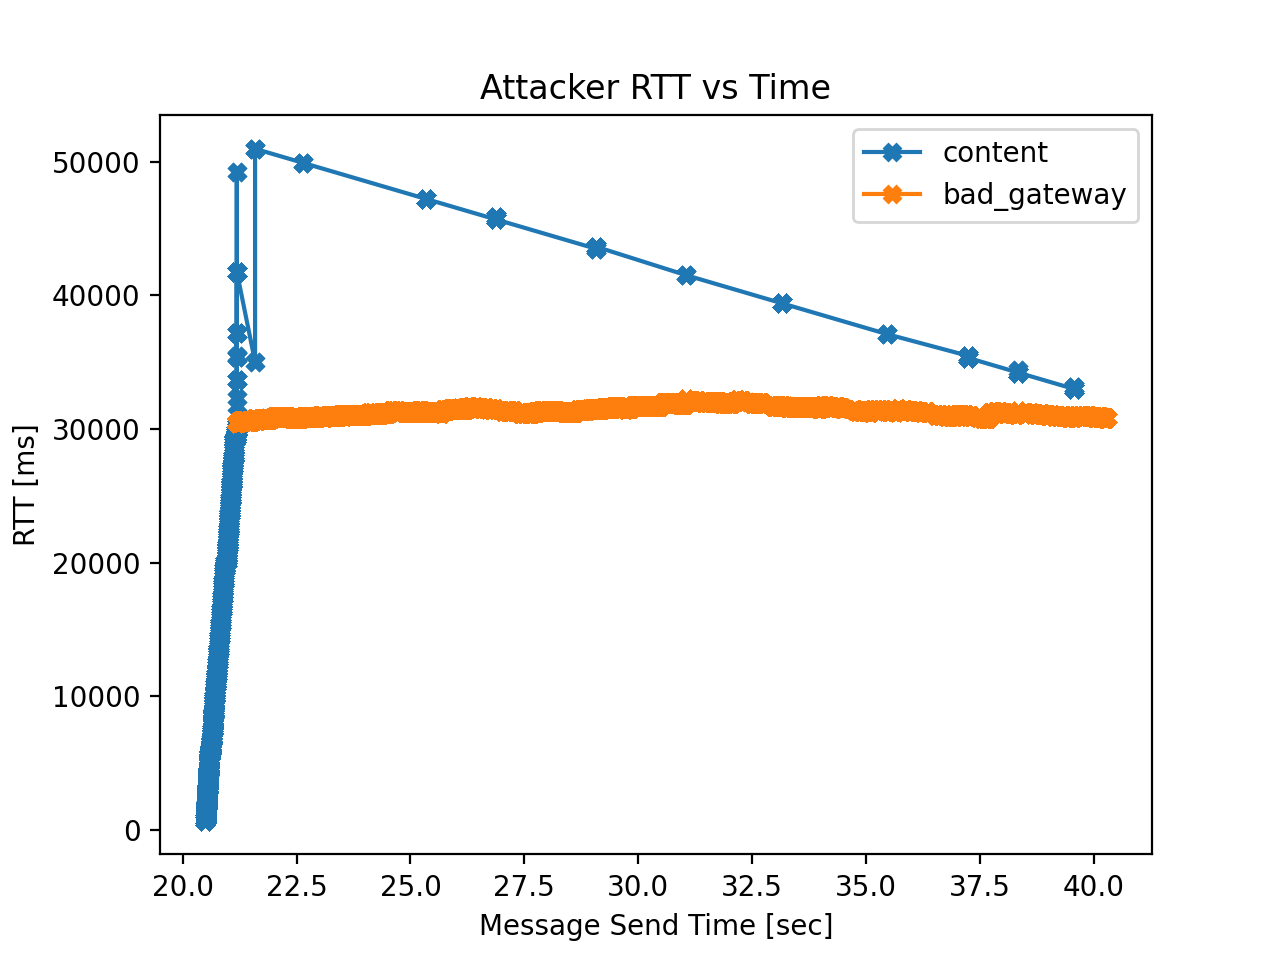

In [11]:
# Plot attacker rtt vs time

ax = None
x="sent_time_ms"
y="attacker_to_receiver_ms"
kind="line"
for coap_code in adbgdf["coap_code"].unique():
    if coap_code is None:
        continue
    _df = adbgdf[adbgdf["coap_code"] == coap_code]
    plot_args = {"kind": kind,
                 "x": x,
                 "y": y,
                 "ax": ax,
                 "marker": "X",
                 "label": coap_code}
    ax = _df.plot(**plot_args)

ax.set_title("Attacker RTT vs Time")
ax.set_ylabel("RTT [ms]")
ax.set_xlabel("Message Send Time [sec]")
plt.show()

<IPython.core.display.Javascript object>


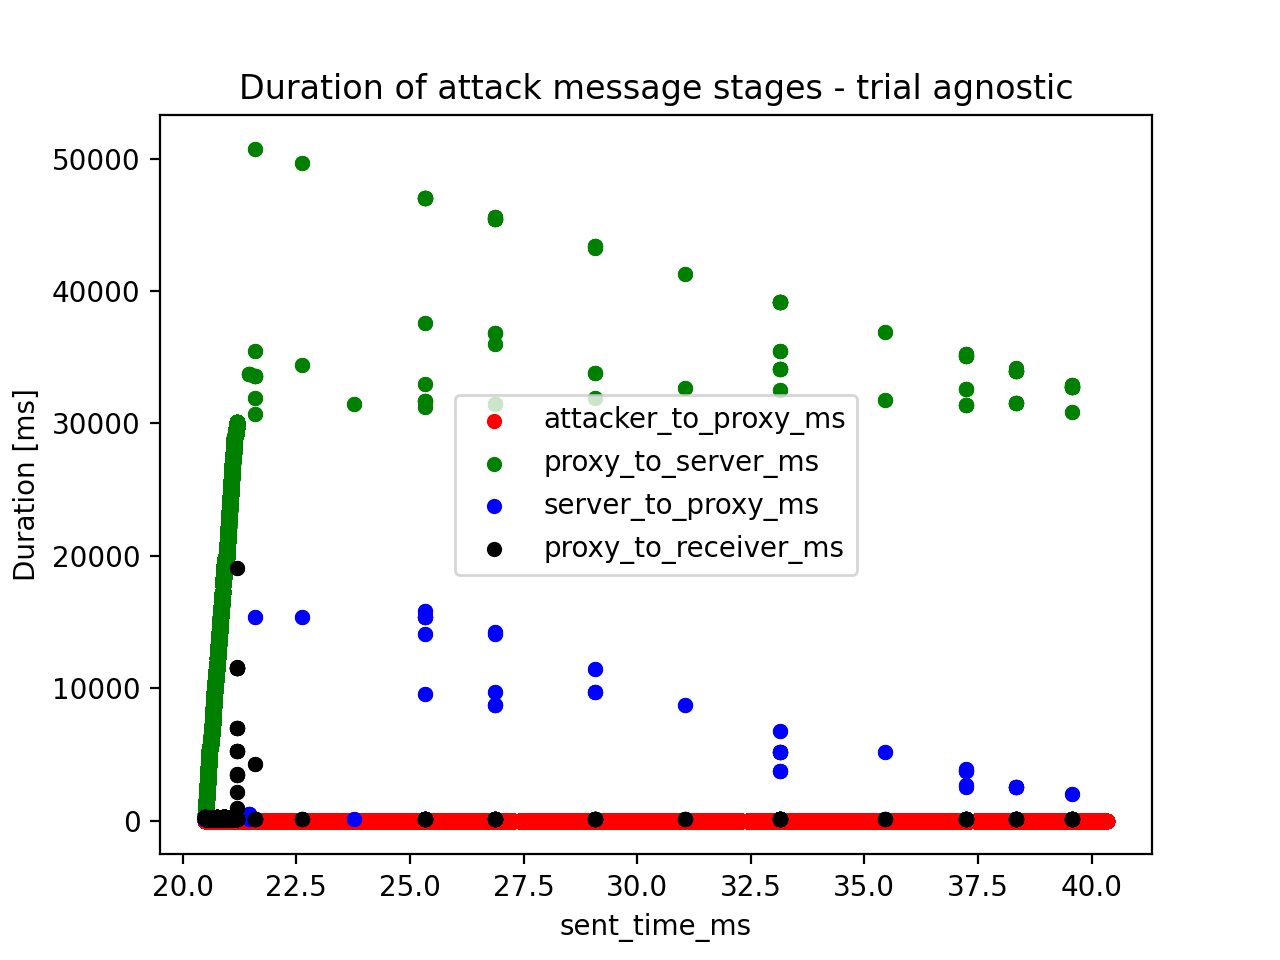

In [12]:
# Plot the duration of different stages of the attack messages

x="sent_time_ms"
kind="scatter"
ax = None
ax = adbgdf.plot(kind=kind, x=x, y="attacker_to_proxy_ms", ax=ax, label="attacker_to_proxy_ms", color='red')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_server_ms", ax=ax, label="proxy_to_server_ms", color='green')
ax = adbgdf.plot(kind=kind, x=x, y="server_to_proxy_ms", ax=ax, label="server_to_proxy_ms", color='blue')
ax = adbgdf.plot(kind=kind, x=x, y="proxy_to_receiver_ms", ax=ax, label="proxy_to_receiver_ms", color='black')

ax.set_ylabel("Duration [ms]")
ax.set_title("Duration of attack message stages - trial agnostic")
ax.legend()

plt.show()